# Ноутбук 1_02_00: EDA и предобработка данных Credit Card Fraud Detection

Содержание
Набор данных содержит транзакции, совершенные европейскими держателями карт с помощью кредитных карт в сентябре 2013 года.
В этом наборе данных представлены транзакции, которые произошли за два дня, и мы имеем 492 случая мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, на положительный класс (мошенничества) приходится 0,172% всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA. Из-за проблем конфиденциальности исходные характеристики и дополнительная справочная информация о данных не предоставлена. Характеристики V1, V2, ... V28 являются основными компонентами, полученными с помощью PCA, единственными характеристиками, которые не были преобразованы с помощью PCA, являются "Время" и "Сумма". Параметр "Время" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Параметр "Сумма" - это сумма транзакции, которую можно использовать, например, для обучения, зависящего от затрат. Параметр "Класс" - это переменная ответа, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

Учитывая коэффициент дисбаланса в классе стоит измерять точность, используя площадь под кривой соответствия точности (AUPRC). Точность матрицы путаницы не имеет значения для несбалансированной классификации.

## 1. Импорты

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings

# Настройки отображения
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 3)
plt.rcParams["figure.titlesize"] = 18
plt.rcParams['font.size'] = 12
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.linewidth"] = 3
# plt.rcdefaults() 

pd.set_option('display.float_format', lambda x: '%.5f' % x)
warnings.filterwarnings('ignore')

# Константы
RANDOM_STATE = 42

## 2. Загрузка данных

In [2]:
# поиск пути от текущего файла в папку 
# anomaly_detection_project\data\raw где лежит датасет
def find_path_within_project(project_name, path_to_data):
    current_path = os.getcwd()   # путь к текущему файлу
  
    while True:
        # Проверяем, находится ли проект в текущем каталоге
        # если найден лепим и возвращаем нужный путь к данным
        if project_name in os.listdir(current_path):
            # Строим путь до нужной папки внутри проекта
            return os.path.join(current_path, project_name, path_to_data)
        
        parent_path = os.path.dirname(current_path)
        
        if parent_path == current_path:
            raise FileNotFoundError(f"Проект '{project_name}' не найден в родительских каталогах.")
        # если проекта нет поднимаемся выше
        current_path = parent_path

# Получаем путь
full_path = find_path_within_project(
    "anomaly_detection_project", 
    os.path.join("data", "raw",'creditcard.csv' )
)

In [3]:
# файл creditcard.csv лежит в папке data/raw/
# print(f"Загрузка данных из {full_path}")
df = pd.read_csv(full_path)

# посмотрим ка
print("\n")
print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"\nДанные. Первые строки:")
display(df.head())



Размер данных: 284807 строк, 31 столбцов

Данные. Первые строки:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00000,-1.35981,-0.07278,2.53635,1.37816,-0.33832,0.46239,0.23960,0.09870,0.36379,...,-0.01831,0.27784,-0.11047,0.06693,0.12854,-0.18911,0.13356,-0.02105,149.62000,0
1,0.00000,1.19186,0.26615,0.16648,0.44815,0.06002,-0.08236,-0.07880,0.08510,-0.25543,...,-0.22578,-0.63867,0.10129,-0.33985,0.16717,0.12589,-0.00898,0.01472,2.69000,0
2,1.00000,-1.35835,-1.34016,1.77321,0.37978,-0.50320,1.80050,0.79146,0.24768,-1.51465,...,0.24800,0.77168,0.90941,-0.68928,-0.32764,-0.13910,-0.05535,-0.05975,378.66000,0
3,1.00000,-0.96627,-0.18523,1.79299,-0.86329,-0.01031,1.24720,0.23761,0.37744,-1.38702,...,-0.10830,0.00527,-0.19032,-1.17558,0.64738,-0.22193,0.06272,0.06146,123.50000,0
4,2.00000,-1.15823,0.87774,1.54872,0.40303,-0.40719,0.09592,0.59294,-0.27053,0.81774,...,-0.00943,0.79828,-0.13746,0.14127,-0.20601,0.50229,0.21942,0.21515,69.99000,0


In [4]:
# Info
print("\nИнфо:")
print(df.info())


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21

In [5]:
# Статистика по числовым признакам
print("\nCтатистика:")
display(df.describe().T)


Cтатистика:


,count,mean,std,min,25%,50%,75%,max
Time,284807.00000,94813.85958,47488.14595,0.00000,54201.50000,84692.00000,139320.50000,172792.00000
V1,284807.00000,0.00000,1.95870,-56.40751,-0.92037,0.01811,1.31564,2.45493
V2,284807.00000,0.00000,1.65131,-72.71573,-0.59855,0.06549,0.80372,22.05773
V3,284807.00000,-0.00000,1.51626,-48.32559,-0.89036,0.17985,1.02720,9.38256
V4,284807.00000,0.00000,1.41587,-5.68317,-0.84864,-0.01985,0.74334,16.87534
V5,284807.00000,0.00000,1.38025,-113.74331,-0.69160,-0.05434,0.61193,34.80167
V6,284807.00000,0.00000,1.33227,-26.16051,-0.76830,-0.27419,0.39856,73.30163
V7,284807.00000,-0.00000,1.23709,-43.55724,-0.55408,0.04010,0.57044,120.58949
V8,284807.00000,0.00000,1.19435,-73.21672,-0.20863,0.02236,0.32735,20.00721
V9,284807.00000,-0.00000,1.09863,-13.43407,-0.64310,-0.05143,0.59714,15.59499


In [6]:
# Анализ целевой переменной
class_dist = df['Class'].value_counts(normalize=True) * 100
print("\nРаспределение классов:")
print(class_dist)


Распределение классов:
Class
0   99.82725
1    0.17275
Name: proportion, dtype: float64


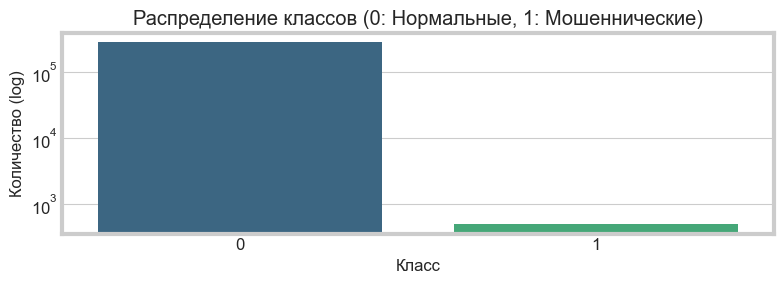

In [7]:
# Визуализация дисбаланса классов
sns.countplot(x='Class', data=df, palette='viridis')
plt.title('Распределение классов (0: Нормальные, 1: Мошеннические)')
plt.xlabel('Класс')
plt.ylabel('Количество (log)')
plt.yscale('log')  # Логарифмическая шкала из-за дисбаланса
plt.show()

## 3. Анализ признаков

### Time

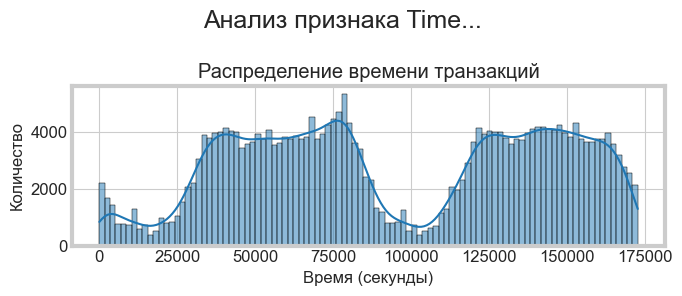

In [8]:
# Анализ временного признака
plt.figure(figsize=(7, 3))
plt.suptitle("Анализ признака Time...")
sns.histplot(df['Time'], bins=100, kde=True)
plt.title('Распределение времени транзакций')
plt.xlabel('Время (секунды)')
plt.ylabel('Количество')
plt.show()

In [9]:
# Извлекаем час и день из Time (в секундах)
df['Time_hour'] = (df['Time'] // 3600) % 24
df['Time_day'] = df['Time'] // (3600 * 24)
df['Time_abs_hour'] = df['Time'] // 3600

### Amount

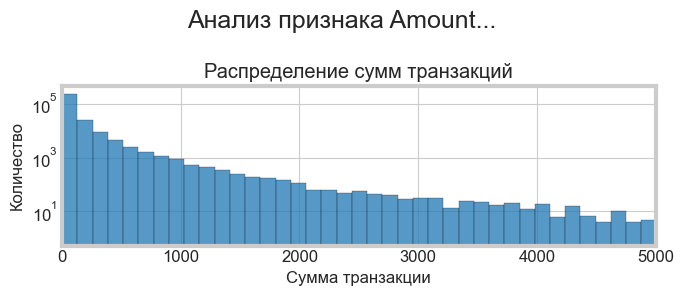

In [10]:
# Анализ суммы транзакций
plt.figure(figsize=(7, 3))
plt.suptitle("Анализ признака Amount...")
sns.histplot(df['Amount'], bins=200, kde=False)
plt.title('Распределение сумм транзакций')
plt.xlabel('Сумма транзакции')
plt.ylabel('Количество')
plt.yscale('log')
plt.xlim(0, 5000)  # Ограничиваем для лучшей визуализации
plt.show()

In [11]:
# лепим логарифмированный Ammount
df['Amount_log'] = np.log1p(df['Amount'])

### V - pca признаки

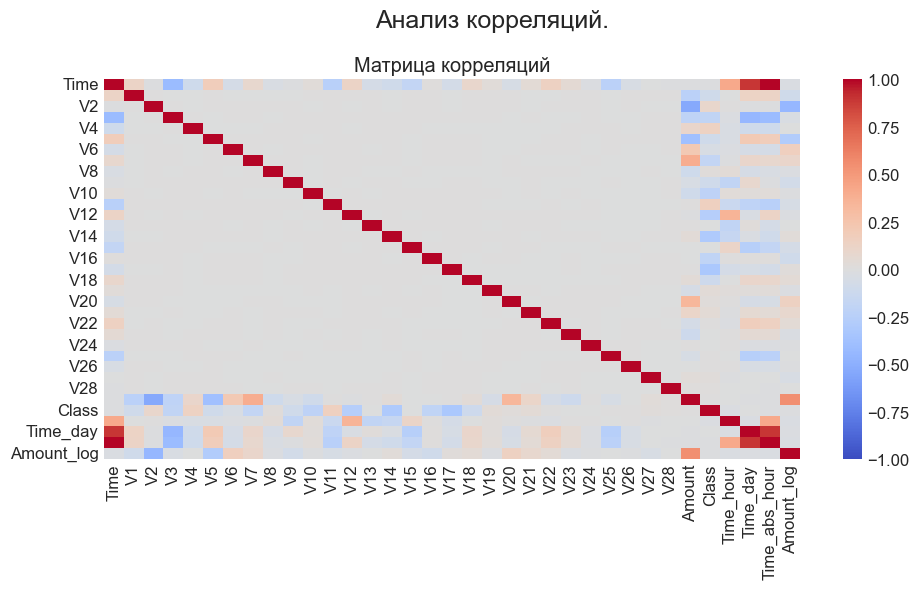


Корреляция признаков с целевой переменной:
Class            1.00000
V11              0.15488
V4               0.13345
V2               0.09129
V21              0.04041
V19              0.03478
V20              0.02009
V8               0.01988
V27              0.01758
V28              0.00954
Amount           0.00563
V26              0.00446
V25              0.00331
V22              0.00081
V23             -0.00269
V15             -0.00422
V13             -0.00457
Time_day        -0.00522
V24             -0.00722
Amount_log      -0.00833
Time            -0.01232
Time_abs_hour   -0.01233
Time_hour       -0.01711
V6              -0.04364
V5              -0.09497
V9              -0.09773
V1              -0.10135
V18             -0.11149
V7              -0.18726
V3              -0.19296
V16             -0.19654
V10             -0.21688
V12             -0.26059
V14             -0.30254
V17             -0.32648
Name: Class, dtype: float64


In [12]:
# Корреляционный анализ

corr_matrix = df.corr()

plt.figure(figsize=(10, 6))
plt.suptitle("Анализ корреляций.")
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляций')
plt.show()

# Корреляция с целевой переменной
class_corr = corr_matrix['Class'].sort_values(ascending=False)
print("\nКорреляция признаков с целевой переменной:")
print(class_corr)

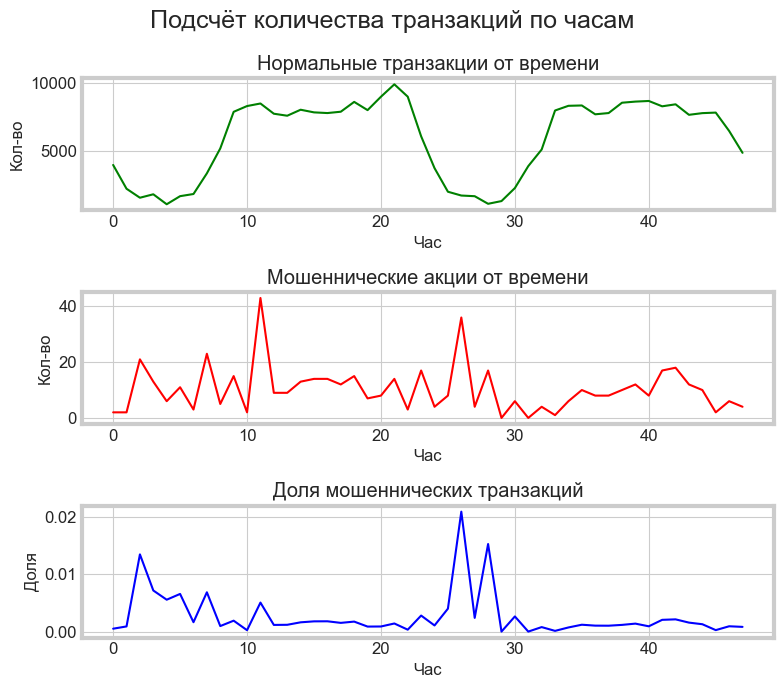

In [13]:
# Подсчёт количества транзакций по часам
count_0 = df[df['Class'] == 0].groupby('Time_abs_hour').count()['Class']
count_1 = df[df['Class'] == 1].groupby('Time_abs_hour').count()['Class']

# Объединение и расчёт отношения
counts_df = pd.concat([count_0, count_1], axis=1, keys=['Class 0', 'Class 1']).fillna(0)
counts_df['ratio'] = (counts_df['Class 1'] / counts_df['Class 0']).replace([np.inf, -np.inf], np.nan).fillna(0)
counts_df = counts_df.reset_index()

# Настройка )
fig, axs = plt.subplots(3, 1, figsize=(8, 7))
plt.suptitle('Подсчёт количества транзакций по часам')

# График 1: Обычные транзакции
sns.lineplot(data=counts_df, x='Time_abs_hour', y='Class 0', ax=axs[0], color='green')
axs[0].set_title('Нормальные транзакции от времени')
axs[0].set_xlabel('Час')
axs[0].set_ylabel('Кол-во')

# График 2: Мошеннические транзакции
sns.lineplot(data=counts_df, x='Time_abs_hour', y='Class 1', ax=axs[1], color='red')
axs[1].set_title('Мошеннические акции от времени')
axs[1].set_xlabel('Час')
axs[1].set_ylabel('Кол-во')

# График 3: Отношение фрода к обычным
sns.lineplot(data=counts_df, x='Time_abs_hour', y='ratio', ax=axs[2], color='blue')
axs[2].set_title('Доля мошеннических транзакций')
axs[2].set_xlabel('Час')
axs[2].set_ylabel('Доля')

plt.tight_layout()
plt.show()

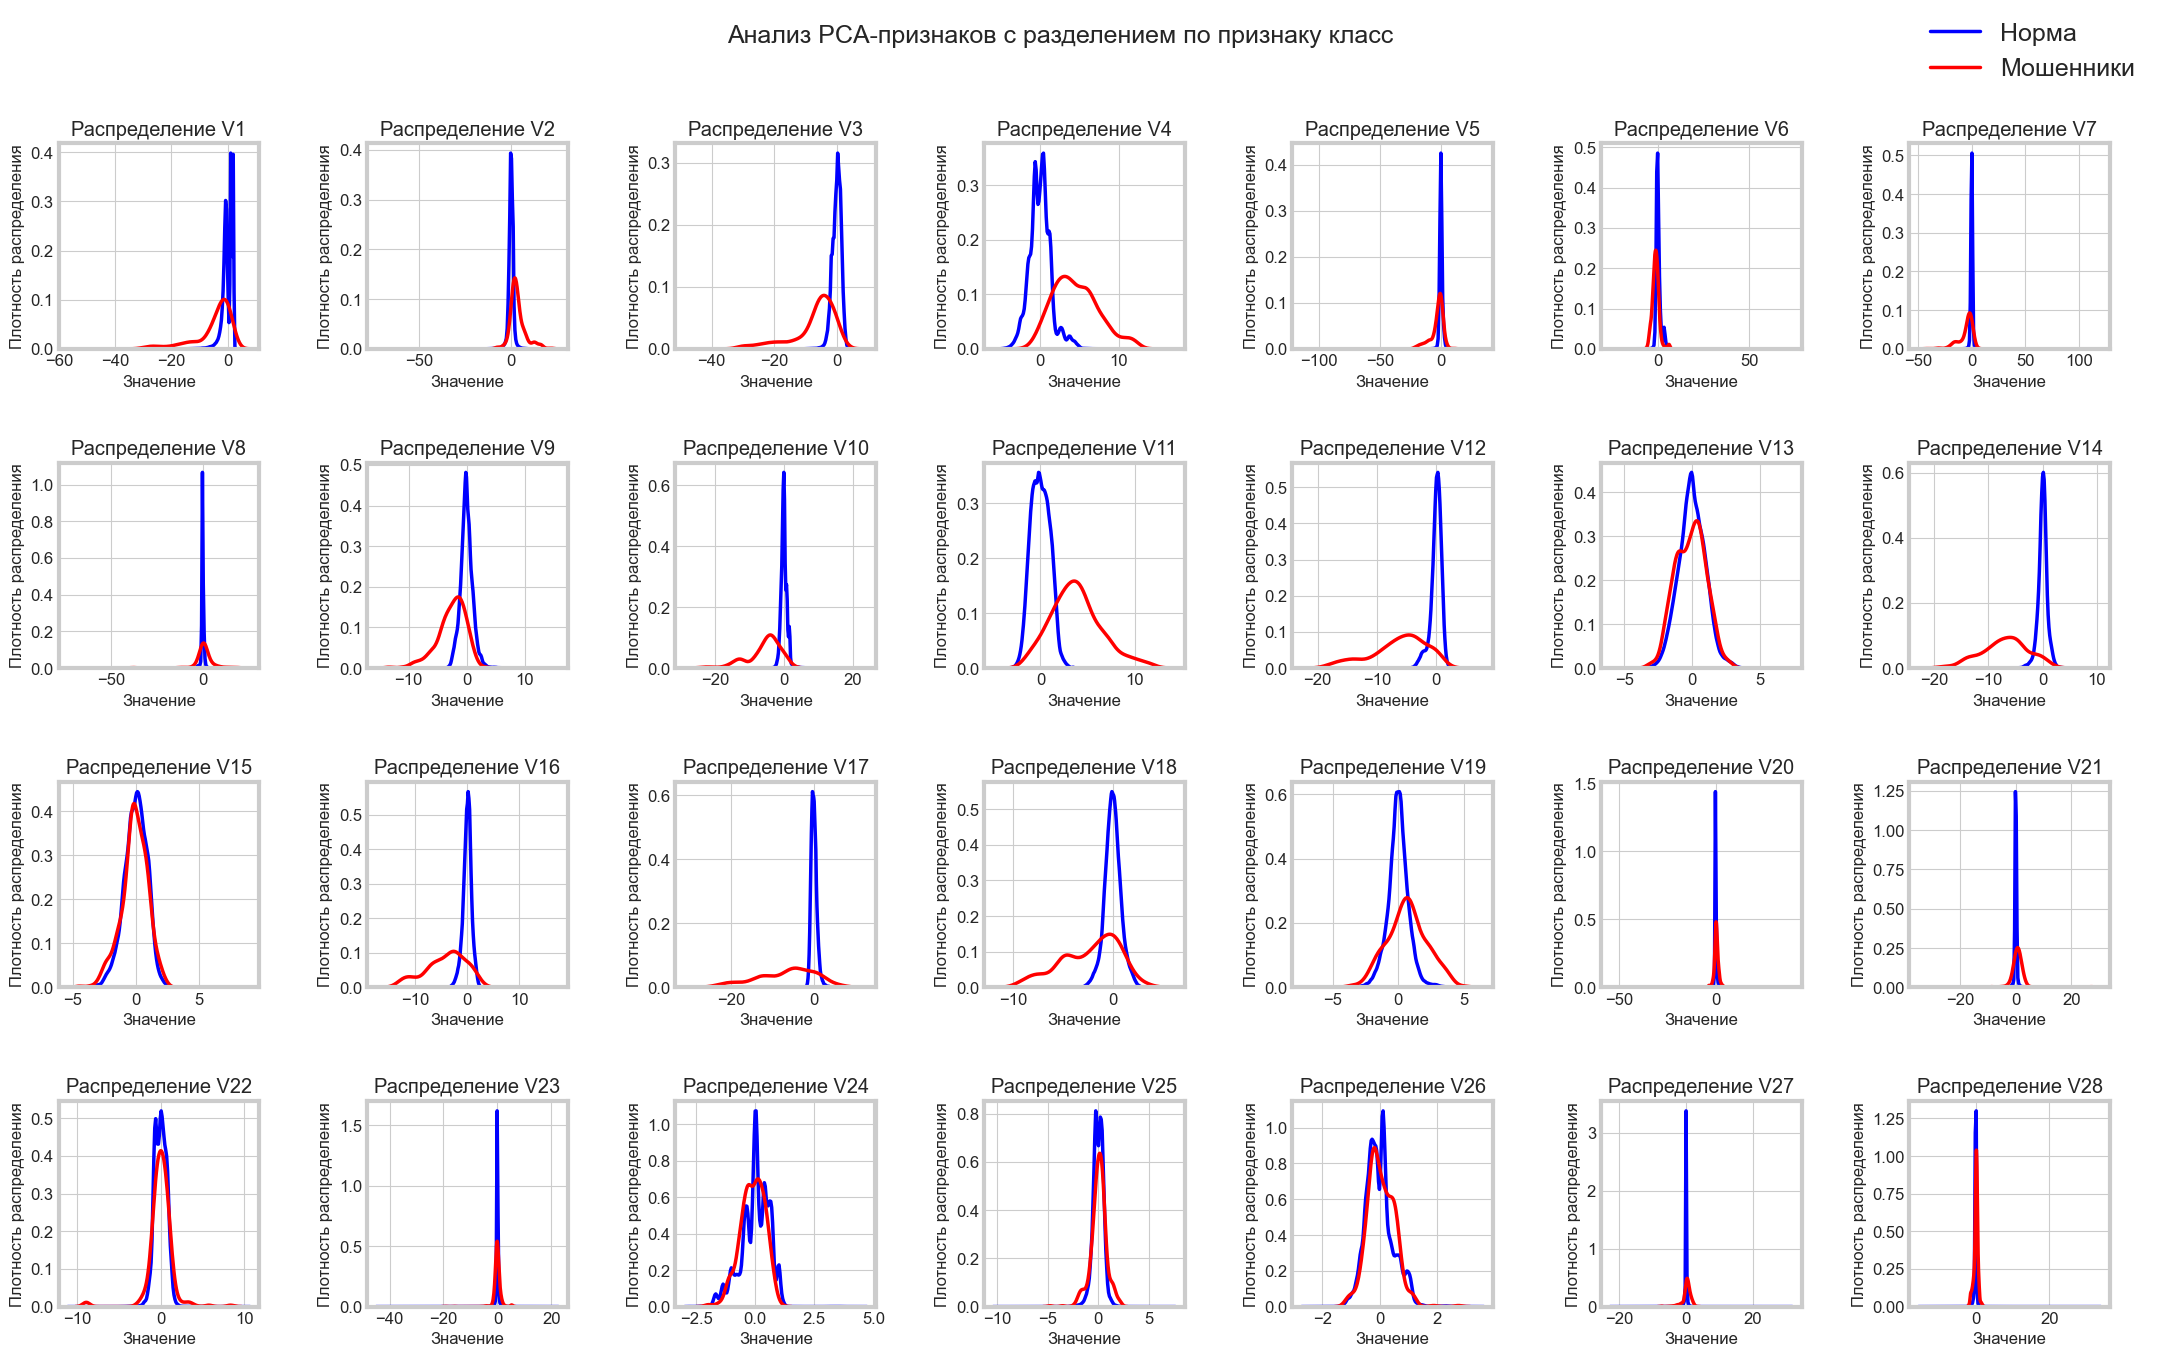

In [14]:
pca_features = [col for col in df.columns if col.startswith('V')]

fig, axs = plt.subplots(4, 7, figsize=(22, 14))
plt.suptitle("Анализ PCA-признаков с разделением по признаку класс")
for idx, ax in enumerate(axs.flat):
    feature = pca_features[idx]
    
    # для нормальных
    sns.kdeplot(  
        x=df[df['Class'] == 0][feature],
        ax=ax,
        linewidth=2.5,
        color='blue',
        # label='Норма'
    )
    # для плохих
    sns.kdeplot(
        x=df[df['Class'] == 1][feature],
        ax=ax,
        linewidth=2.5,
        color='red'
    )

    ax.set_title(f"Распределение {feature}")
    ax.set_xlabel("Значение")
    ax.set_ylabel("Плотность распределения")
    
# Добавляем общую легенду
fig.legend(['Норма', 'Мошенники'], loc='upper right', fontsize=18)
fig.tight_layout(pad=3.0)
plt.show()

## 4. Применение PCA для визуализации

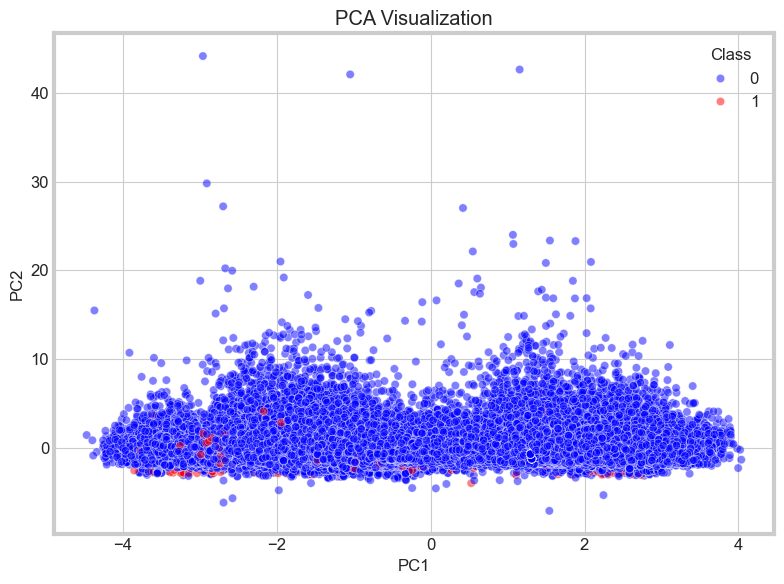

In [15]:
# PCA
X = df.drop(['Class', 'Amount'], axis=1)
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette={0: 'blue', 1: 'red'}, alpha=0.5)
plt.title("PCA Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## 5. t-SNE визуализация

Применение t-SNE для визуализации df_processed ...
t-SNE выполнен за 8.29 сек.


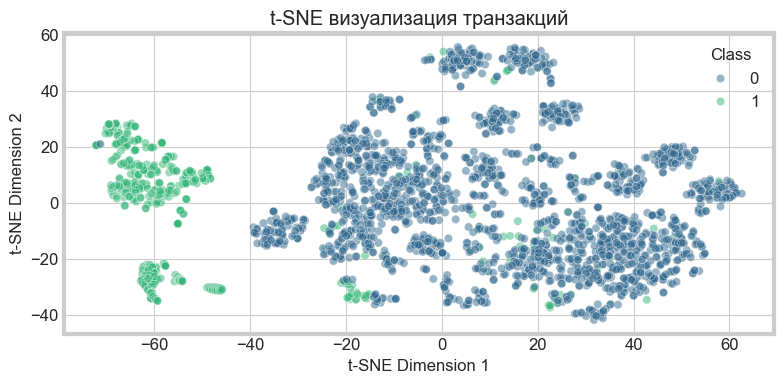

In [16]:
# t-SNE визуализация (только для подвыборки из-за вычислительной сложности)
print("Применение t-SNE для визуализации df_processed ...")
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, n_jobs=-1)


# # Берем подвыборку для t-SNE
# Преобразуем массив в DataFrame, чтобы удобно фильтровать
X_df = pd.DataFrame(X_scaled)

# Добавим столбец с метками
X_df["target"] = y.values

# Отбираем все единицы
class_1 = X_df[X_df["target"] == 1]

# Отбираем случайные 5000 нулей
class_0_sampled = X_df[X_df["target"] == 0].sample(n=2000, random_state=42)

# Соединяем
combined = pd.concat([class_1, class_0_sampled])

start_time = time.time()
X_tsne = tsne.fit_transform(combined.drop(columns="target"))
print(f"t-SNE выполнен за {time.time() - start_time:.2f} сек.")

plt.figure(figsize=(8, 4))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=combined["target"], 
                palette='viridis', alpha=0.5)
plt.title('t-SNE визуализация транзакций')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Class')
plt.show()

## 6. Сохранение обработанных данных

In [17]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,Time_hour,Time_day,Time_abs_hour,Amount_log
0,0.00000,-1.35981,-0.07278,2.53635,1.37816,-0.33832,0.46239,0.23960,0.09870,0.36379,...,0.12854,-0.18911,0.13356,-0.02105,149.62000,0,0.00000,0.00000,0.00000,5.01476
1,0.00000,1.19186,0.26615,0.16648,0.44815,0.06002,-0.08236,-0.07880,0.08510,-0.25543,...,0.16717,0.12589,-0.00898,0.01472,2.69000,0,0.00000,0.00000,0.00000,1.30563
2,1.00000,-1.35835,-1.34016,1.77321,0.37978,-0.50320,1.80050,0.79146,0.24768,-1.51465,...,-0.32764,-0.13910,-0.05535,-0.05975,378.66000,0,0.00000,0.00000,0.00000,5.93928
3,1.00000,-0.96627,-0.18523,1.79299,-0.86329,-0.01031,1.24720,0.23761,0.37744,-1.38702,...,0.64738,-0.22193,0.06272,0.06146,123.50000,0,0.00000,0.00000,0.00000,4.82431
4,2.00000,-1.15823,0.87774,1.54872,0.40303,-0.40719,0.09592,0.59294,-0.27053,0.81774,...,-0.20601,0.50229,0.21942,0.21515,69.99000,0,0.00000,0.00000,0.00000,4.26254


In [18]:
# Мы не сильно что здесь изменили, то и сохраним пока в сырых данных
SAVE_PATH = find_path_within_project(
    "anomaly_detection_project", 
    os.path.join("data", "raw",'creditcard_1_02_00.csv' )
) 


# Сохранение обработанных данных
print(f"Сохранение обработанных данных в {SAVE_PATH}...")
df.to_csv(SAVE_PATH, index=False)
print("Данные успешно сохранены!")

# Проверка сохраненных данных
print("\nИнформация о сохраненных данных:")
print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Распределение классов:\n{df['Class'].value_counts(normalize=True)}")

Сохранение обработанных данных в E:\Projects_ML_2025\anomaly_detection_project\data\raw\creditcard_1_02_00.csv...
Данные успешно сохранены!

Информация о сохраненных данных:
Размер данных: 284807 строк, 35 столбцов
Распределение классов:
Class
0   0.99827
1   0.00173
Name: proportion, dtype: float64


## 7. Заключение

### 1. **Загрузка и первичный анализ данных**
- **Вывод**: Датасет содержит 284 807 транзакций и 31 признак. Все признаки числовые, пропущенных значений нет.
- **Признаки**:
  - **Time**: время в секундах от первой транзакции. Распределение показывает пики активности, вероятно, связанные с часами работы.
  - **Amount**: сумма транзакции. Сильно правостороннее распределение с большим количеством мелких платежей.
  - **V1-V28**: признаки, полученные в результате PCA. Распределения близки к нормальному, но есть выбросы.

### 2. **Анализ целевой переменной (Class)**
- **Вывод**: Крайне сильный дисбаланс классов:
  - **99.83%** — нормальные транзакции (0),
  - **0.17%** — мошеннические (1).
- **Риск**: Модели могут игнорировать редкий класс, если не применить стратегии балансировки.

### 3. **Корреляционный анализ**
- **Вывод**: Большинство признаков имеют слабую корреляцию с целевой переменной.
- **Наиболее информативные признаки** (по абсолютной корреляции):
  - **V11** (0.15),
  - **V4** (0.13),
  - **V2** (0.09),
  - **V14, V17, V12** — сильно отрицательно коррелированы.
- **Time и Amount** почти не коррелируют с целевой переменной (менее 0.01).

### 5. **Предобработка данных**
- **Time**: распарсили по часам и дням.
- **Amaunt**: добавили Amount_log.

### 6. **Визуализация**
- **PCA**: Показывает , что классы сильно перемешаны.
- **t-SNE**: Подтверждает сложность разделения классов — точки сильно перемешаны.

### 7. **Сохранение данных**
- ссохранили с минимальной обработкой.
- 
---

### Общие выводы:
- **Данные сильно несбалансированы** — это главная проблема.
- **Признаки V11, V4, V2, V14, V17, V12** наиболее полезны для модели.
- **PCA/t-SNE** показывают, что мошенничество трудно отделимо... однако - "Никто кроме нас!"

## Happy end.....